# Autoencoder
This model using one of autoencoder abilities that allow to compare input and output. Based on that, autoencoder could determine if sample is normal or anomalous.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

## Data preparation

In [2]:
dataframe = pd.read_csv('../dataset/ecg_prod_10k.csv', header=None)
raw_data = dataframe.values

labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=50)


train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## Set models parameters

In [3]:
latent_dim = 64
input_dim = 140

## Define encoder model

In [4]:
def build_encoder():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(latent_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(input_dim, activation='relu'))
    return model

## Define decoder model

In [5]:
def build_decoder():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(input_dim, activation='sigmoid'))
    return model

## Define autoencoder

In [6]:
def build_autoencoder():
    encoder = build_encoder()
    decoder = build_decoder()

    encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)
    decoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)

    encoder_input = tf.keras.layers.Input(shape=(input_dim,))
    autoencoder_input = encoder(encoder_input)
    autoencoder_output = decoder(autoencoder_input)
    autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=autoencoder_output)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)

    return autoencoder

In [7]:
autoencoder = build_autoencoder()

## Model fitting

In [8]:
autoencoder.fit(normal_train_data, normal_train_data, epochs=100, batch_size=256, validation_data=(test_data, test_data), validation_batch_size=128)

Epoch 1/100
24/24 [==============================] - 2s 16ms/step - loss: 0.6871 - val_loss: 0.6840
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.6830 - val_loss: 0.6840
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.6830 - val_loss: 0.6840
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.6830 - val_loss: 0.6840
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6830 - val_loss: 0.6839
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.6830 - val_loss: 0.6839
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.6830 - val_loss: 0.6839
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6830 - val_loss: 0.6840
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6830 - val_loss: 0.6839
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.6830 - val_loss: 0.6840
Epoch 1

## Save model

In [9]:
dataframe = pd.read_csv('../dataset/ecg_prod_100k.csv', header=None)
random_dataframe = dataframe
raw_data = random_dataframe.values

labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
result = autoencoder.predict(data)


def mean_squared_error(y, y_pred):
    # Calculate the squared errors
    squared_errors = (y - y_pred) ** 2

    # Mean of the sum of squared errors
    mse = np.mean(squared_errors)

    return mse


mse = []

for i in range(len(result)):
    mse.append(mean_squared_error(data[i], result[i]))
correctly_recognized_samples_normal = 0
correctly_recognized_samples_anomalous = 0
temp = []
corr_max = [0, float('inf')]
for i in np.arange(0.001, 0.02, 0.001):
    for j in range(0, len(mse)):
        if mse[j] > i and labels[j] == 0:
            correctly_recognized_samples_anomalous += 1
        if mse[j] < i and labels[j] == 1:
            correctly_recognized_samples_normal += 1
    if abs(correctly_recognized_samples_normal / 75000 - correctly_recognized_samples_anomalous / 25000) < corr_max[1]:
        corr_max = [i,
                    (correctly_recognized_samples_normal / 75000 + correctly_recognized_samples_anomalous / 25000) / 2]
        temp = [correctly_recognized_samples_normal, correctly_recognized_samples_anomalous]
    correctly_recognized_samples_normal = 0
    correctly_recognized_samples_anomalous = 0
print(corr_max)

3125/3125 [==============================] - 5s 2ms/step
[0.004, 0.71824]


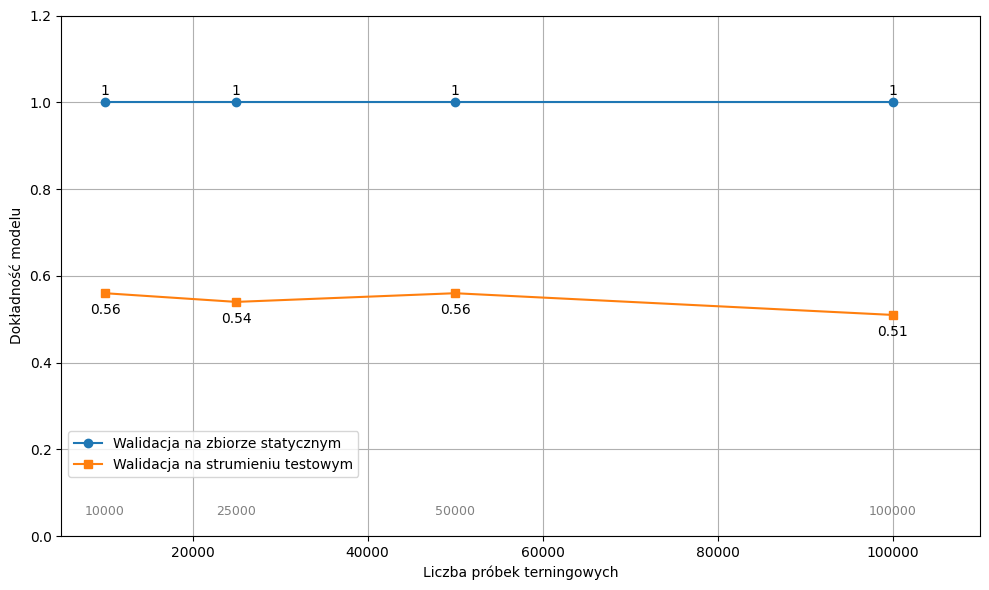

In [6]:
import matplotlib.pyplot as plt

# Define the x-axis values
x = [10000, 25000, 50000, 100000]

# Define the y-values for the two functions
y1 = [1, 1, 1, 1]
y2 = [0.56, 0.54, 0.56, 0.51]

# Create the plot
plt.figure(figsize=(10,6))

# Plot the two functions
plt.plot(x, y1, 'o-', label='Walidacja na zbiorze statycznym')
plt.plot(x, y2, 's-', label='Walidacja na strumieniu testowym')

# Annotate the y-values on the plot for each point
for xi, y1i, y2i in zip(x, y1, y2):
    plt.annotate(f"{y1i}", (xi, y1i), textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(f"{y2i}", (xi, y2i), textcoords="offset points", xytext=(0,-15), ha='center')

    # Annotate x-values for each point
    offset = -30 if y1i < y2i else 15  # Adjust offset based on the lower y value
    plt.annotate(f"{xi}", (xi, 0), textcoords="offset points", xytext=(0,offset), ha='center', fontsize=9, color='gray')

# Set y-limits and x-limits
plt.ylim(0, 1.2)
plt.xlim(5000, 110000)

# Label the axes
plt.xlabel("Liczba próbek terningowych")
plt.ylabel("Dokładność modelu")

# Display the legend in the bottom left with an increased margin from the bottom
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.1))

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
autoencoder.save('../models/detectors/autoencoder_50k')

INFO:tensorflow:Assets written to: ../models/detectors/autoencoder_50k\assets


INFO:tensorflow:Assets written to: ../models/detectors/autoencoder_50k\assets


## Model testing